# Análise de Risco de Crédito

In [18]:
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt

import talos as ta

from imblearn.over_sampling import RandomOverSampler

from keras.activations import sigmoid
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.optimizers import SGD

from numpy import concatenate, vstack, argmin

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Use

In [2]:
# Construir DataFrame a partir da base de dados.
data_set = pd.read_csv('data/TRN', sep='\t', index_col=0)

In [3]:
# Exibe as 5 primeiras linhas da base de dados.
data_set.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
INDEX,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0


In [4]:
# Separa as classes em DataFrames distintos.
class_1_df = data_set.loc[data_set['IND_BOM_1_2'] == 0] # Bom pagador.
class_2_df = data_set.loc[data_set['IND_BOM_1_2'] == 1] # Mau pagador.

In [5]:
# Separa "features" dos "targets" para cada classe, transformando-os em numpy arrays.
class_1_X = class_1_df.iloc[:, :-2].values
class_1_y = class_1_df.iloc[:, -1].values

class_2_X = class_2_df.iloc[:, :-2].values
class_2_y = class_2_df.iloc[:, -1].values

In [6]:
# Treino: 50%, Validação: 25%, Teste: 25% (para ambas as classes).
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(
    class_1_X, class_1_y, test_size=0.25, random_state=42, stratify=class_1_y)

class_1_X_train, class_1_X_val, class_1_y_train, class_1_y_val = train_test_split(
    class_1_X_train, class_1_y_train, test_size=(1./3), random_state=42, stratify=class_1_y_train)

class_2_X_train, class_2_X_test, class_2_y_train, class_2_y_test = train_test_split(
    class_2_X, class_2_y, test_size=0.25, random_state=42, stratify=class_2_y)

class_2_X_train, class_2_X_val, class_2_y_train, class_2_y_val = train_test_split(
    class_2_X_train, class_2_y_train, test_size=(1./3), random_state=42, stratify=class_2_y_train)

In [7]:
# Concatena os arrays de treinamento das classes (features e targets).
X_train = vstack((class_1_X_train, class_2_X_train))
y_train = concatenate([class_1_y_train, class_2_y_train])

# Concatena os arrays de validação das classes (features e targets).
X_val = vstack((class_1_X_val, class_2_X_val))
y_val = concatenate([class_1_y_val, class_2_y_val])

# Concatena os arrays de teste das classes (features e targets).
X_test = vstack((class_1_X_test, class_2_X_test))
y_test = concatenate([class_1_y_test, class_2_y_test])

In [8]:
# Over-sampling os conjuntos de treinamento e validação da classe 2 (minoritária).
ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

In [9]:
def credit_risk_analisys_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['first_neuron'], activation='tanh', input_dim=x_train.shape[1]))
    
    model.add(Dense(1, activation=params['last_activation']))
              
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    verbose=2,
                    callbacks=early_stopper(params['epochs'], mode='strict'))

    return out, model

In [10]:
p = {'lr': [0.01, 0.1, 0.5, 1.0, 1.5, 3.0],
     'first_neuron':[2, 32, 128, 256],
     'batch_size': [64],
     'epochs': [100000],
     'optimizer': [SGD],
     'loss': [mean_squared_error],
     'last_activation': [sigmoid]}

In [ ]:
h = ta.Scan(x=X_train, y=y_train, params=p,
            x_val=X_val, y_val=y_val,
            dataset_name='credit_risk_analisys',
            experiment_no='1',
            model=credit_risk_analisys_model)

In [11]:
# use Scan object as input
# r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('credit_risk_analisys_1.csv')

In [12]:
# access the dataframe with the results
r.data.head(-3)

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,batch_size,epochs,optimizer,loss.1,last_activation
0,14,0.206014,0.676043,0.204375,0.678077,3.00,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
1,22,0.207046,0.674728,0.206099,0.675589,1.00,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
2,105,0.206730,0.674553,0.206092,0.675774,0.10,128,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
3,35,0.207065,0.673484,0.206496,0.674330,0.50,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
4,20,0.206493,0.676146,0.205075,0.677660,1.50,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
5,7,0.208364,0.675478,0.206102,0.676119,3.00,128,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
6,8,0.206776,0.674481,0.206272,0.674762,1.50,256,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
7,15,0.206729,0.674471,0.206226,0.675076,1.50,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
8,7,0.206935,0.674697,0.206085,0.675261,3.00,256,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
9,47,0.205942,0.676937,0.205138,0.677357,0.50,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>


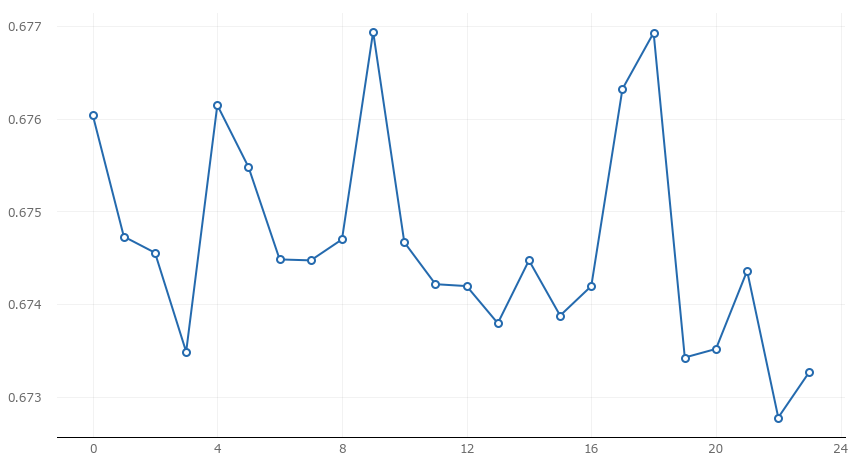

In [13]:
# line plot
r.plot_line()

In [19]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

      Iter       Train Loss   Remaining Time 
         1           1.2776           11.96m
         2           1.2690           11.29m
         3           1.2617           11.19m
         4           1.2554           10.86m
         5           1.2492           10.78m
         6           1.2445           10.76m
         7           1.2399           10.72m
         8           1.2352           10.67m
         9           1.2318           10.57m
        10           1.2266           10.43m
        11           1.2236           10.35m
        12           1.2207           10.26m
        13           1.2182           10.19m
        14           1.2160           10.15m
        15           1.2141           10.05m
        16           1.2106            9.97m
        17           1.2079            9.87m
        18           1.2056            9.75m
        19           1.2042            9.63m
        20           1.2028            9.52m
        21           1.2007            9.44m
        2

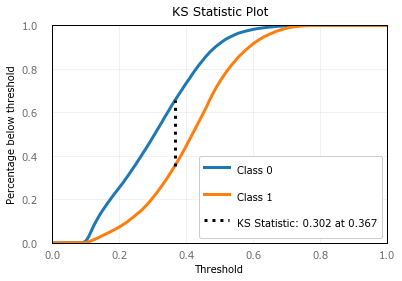


Accuracy:         0.6898
Recall:           0.2581
Precision:        0.6197
F1:               0.3644
AUROC:            0.7065
AUPR:             0.5463


In [22]:
gb_clf = GradientBoostingClassifier(verbose=2)  # Modifique aqui os hyperparâmetros
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


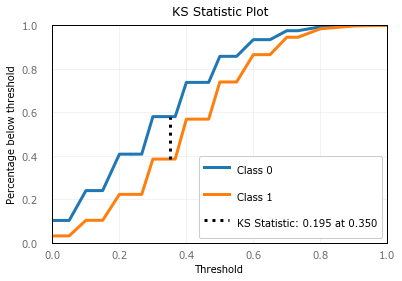


Accuracy:         0.6518
Recall:           0.2604
Precision:        0.4900
F1:               0.3401
AUROC:            0.6331
AUPR:             0.4407


In [21]:
rf_clf = RandomForestClassifier(verbose=2)  # Modifique aqui os hyperparâmetros
rf_clf.fit(X_train, y_train)
rf_pred_class = rf_clf.predict(X_val)
rf_pred_scores = rf_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

# Run SVM with GridSearch

In [ ]:
tuned_parameters = {'kernel': ['rbf', 'linear'], 'gamma': [0.001, 0.0001, 0.00001],
                     'C': [1, 10, 100, 1000]}

In [ ]:
print("# Tuning hyper-parameters for accuracy")
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                   scoring = 'accuracy')
clf.fit(X_train, y_train)

In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)

print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))